In [1]:
from traffic.core.mixins import PointMixin

class Point(PointMixin):
    """This mixin provides the interface to plot the elements on maps."""

    def __init__(self, lat, lon, name):
        self.latitude = lat
        self.longitude = lon
        self.name = name


procedure_points = {
    "IFBAP": Point(lat=53.541889, lon=-6.668389, name="IFBAP"),
    "OSLEX": Point(lat=53.3655, lon=-6.95125, name="OSLEX"),
    "NEPAM": Point(lat=60.486378, lon=5.018094, name="NEPAM"),
    "GILVA": Point(lat=60.508089, lon=5.280411, name="GILVA"),
    "RIVIP": Point(lat=60.074225, lon=5.158156, name="RIVIP"),
    "GODID": Point(lat=60.095667, lon=5.417281, name="GODID"),
    "BAVAD": Point(lat=60.466111, lon=11.084444, name="BAVAD"),
    "TITLA": Point(lat=60.421361, lon=11.402722, name="TITLA"),
    "ANYANG": Point(lat=37.413611, lon=126.928333, name="ANYANG"),
    "GEBKA": Point(lat=59.841778, lon=29.933556, name="GEBKA"),
    "MADID": Point(lat=59.758361, lon=30.5875, name="MADID"),
    "LEPTO": Point(lat=59.852583, lon=29.954667, name="LEPTO"),
    "RAVSA": Point(lat=51.474725, lon=0.920478, name="RAVSA"),
    "AMVES": Point(lat=4.912775, lon=-74.415681, name="AMVES"),
    "BIPRI": Point(lat=59.747917, lon=30.565639, name="BIPRI"),
}

In [14]:
from tqdm.autonotebook import tqdm
from traffic.data import opensky
from pyopensky.schema import StateVectorsData4
from sqlalchemy import func 
from traffic.data import airports
import pandas as pd
from traffic.core import Traffic

airp = 'ENBR'
PM_point = 'RIVIP'
start_d = 1
stop_d = 31 +1
month = "2022-10-"
distance_min = 8
distance_max = 12
count = 0
days = pd.Series()
pm_fl = Traffic(pd.DataFrame())
fl_all = Traffic(pd.DataFrame())
for date in range(start_d,stop_d):
#    if date == 24:
#        continue
    lat, lon = airports[airp].latlon
    t = opensky.history(
        month + str(date) + " 00:00", month + str(date) + " 23:59",
        func.ST_Distance(
            func.to_spherical_geography(func.ST_Point(lon, lat)),
            func.to_spherical_geography(
                func.ST_Point(StateVectorsData4.lon, StateVectorsData4.lat)
            ),
        )
        <= 50 * 1858,
        arrival_airport=airp).sort_values('timestamp')
    t = t.assign_id().eval()

    def pm(flight):
        return flight.point_merge(
        #PM_point, distance_interval=(distance_min, distance_max)
        procedure_points[PM_point], distance_interval=(distance_min, distance_max)
    ).next()

    t_pm= t.iterate_lazy().pipe(pm).eval()
    fl_all = fl_all + t
    if t_pm is None:
        pass
    else:
        count = count + len(t_pm)
        pm_fl = pm_fl + t_pm
        days = pd.concat([days,pd.Series(date)])
        #t_pm.to_csv('pm_'+airp+'_'+str(date)+'_'+PM_point+'.csv')
        t_pm | t | (t & t_pm)
pm_fl.to_csv('pm_'+airp+'_'+PM_point+'_FULL_month.csv')

C:\Users\lucsm87\AppData\Local\Compiling\ipykernel_18984\1426716316.py:49: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days = pd.concat([days,pd.Series(date)])
C:\Users\lucsm87\.conda\envs\traffic\lib\site-packages\pyproj\geod.py:404: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._inv_point(
C:\Users\lucsm87\.conda\envs\traffic\lib\site-packages\pyproj\geod.py:404: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [15]:
count

9

In [36]:
t_pm | t | (t & t_pm) | t_pm3


,count
flight_id,
RYR17NG_239,779
EIN7T9_098,779
N101QS_331,685
CLF699_028,590
EAI43D_244,580
RYR69NK_159,578
EIN605P_190,576
DCS701_025,564
RYR3YW_281,560


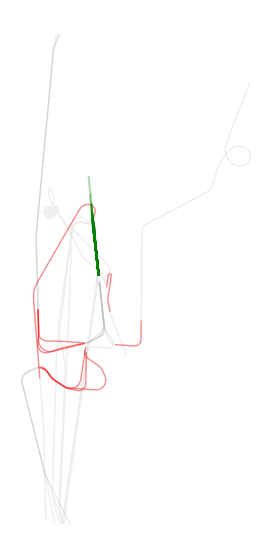

In [16]:
import matplotlib.pyplot as plt
from cartes.crs import EuroPP
from cartes.crs import EPSG_5174 #RKSI projection
from cartes.crs import EPSG_9377 #SKBO projection
from cartes.crs import EPSG_2465 #ULLI projection


with plt.style.context('traffic'):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EuroPP()))
    (fl_all & pm_fl).plot(ax, alpha=.2)
    pm_fl.plot(ax, color="red", alpha=.4)
    for flight in t:
        
        for segment in flight.aligned_on_ils(airp):
            segment.plot(ax, color="green", alpha=.3)
            
plt.savefig(r'C:\Users\lucsm87\OneDrive - Linköpings universitet\Opensky23\Traffic_pictures\_'+airp+'_'+PM_point+'_PM_num_flights_'+str(len(pm_fl))+'.jpg',bbox_inches='tight')
fig